# Fashion Mnist 분류 모델 성능 개선


- 일반 Mnist도 CNN방법으로 수행하였습니다.
- BatchNormalization적용, 필터사이즈, 스트라이드, 레이어 갯수 등을 바꿔가면서 해보았는데 93%가 한계였습니다.

## 필요한 라이브러리 불러오기

In [64]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import LeakyReLU

from sklearn.model_selection import train_test_split

## 데이터 불러오기

In [65]:
(x_train_full, y_train_full), (x_test, y_test) = load_data()

print(x_train_full.shape)
print(y_train_full.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 데이터 전처리

In [66]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3)

In [67]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(42000, 28, 28)
(42000,)
(10000, 28, 28)
(10000,)
(18000, 28, 28)
(18000,)


In [68]:
x_train[0].shape

(28, 28)

## 모델 만들기

In [132]:
def build_model():
  model = Sequential()

  input = Input(shape=(28, 28, 1))
  output = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=1, padding='same')(output)
  output = Dropout(0.3)(output)

  output = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=1, padding='same')(output)
  output = Dropout(0.3)(output)

  output = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=1, padding='same')(output)
  output = Dropout(0.3)(output)

  output = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=1, padding='same')(output)
  output = Dropout(0.5)(output)

  output = BatchNormalization()(output)
  output = Flatten()(output)
  output = Dense(units=256, activation='relu', kernel_initializer='he_normal')(output)
  output = Dropout(0.5)(output)
  output = Dense(units=128, activation='relu', kernel_initializer='he_normal')(output)
  output = Dropout(0.5)(output)
  output = Dense(units=10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

  return model

In [133]:
model_1 = build_model()
model_1.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 28, 28, 64)      

## 모델 학습 (Callback 으로 EarlyStopping 사용)

In [134]:
callbacks = EarlyStopping(patience=5, monitor='val_acc', 
                                  restore_best_weights=True)
hist = model_1.fit(x_train, y_train, epochs = 100, verbose=True, batch_size=128, validation_data = (x_val, y_val), callbacks=callbacks)

Epoch 1/100
329/329 [==============================] - 10s 29ms/step - loss: 0.9208 - acc: 0.6737 - val_loss: 0.7697 - val_acc: 0.7219
Epoch 2/100
329/329 [==============================] - 9s 29ms/step - loss: 0.5226 - acc: 0.8110 - val_loss: 0.4447 - val_acc: 0.8317
Epoch 3/100
329/329 [==============================] - 10s 29ms/step - loss: 0.4391 - acc: 0.8452 - val_loss: 0.3546 - val_acc: 0.8738
Epoch 4/100
329/329 [==============================] - 10s 29ms/step - loss: 0.3896 - acc: 0.8595 - val_loss: 0.3389 - val_acc: 0.8806
Epoch 5/100
329/329 [==============================] - 9s 29ms/step - loss: 0.3685 - acc: 0.8705 - val_loss: 0.3084 - val_acc: 0.8855
Epoch 6/100
329/329 [==============================] - 9s 29ms/step - loss: 0.3411 - acc: 0.8799 - val_loss: 0.3088 - val_acc: 0.8899
Epoch 7/100
329/329 [==============================] - 9s 29ms/step - loss: 0.3293 - acc: 0.8832 - val_loss: 0.2636 - val_acc: 0.9053
Epoch 8/100
329/329 [==============================] - 9s 2

In [135]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## 결과 시각화

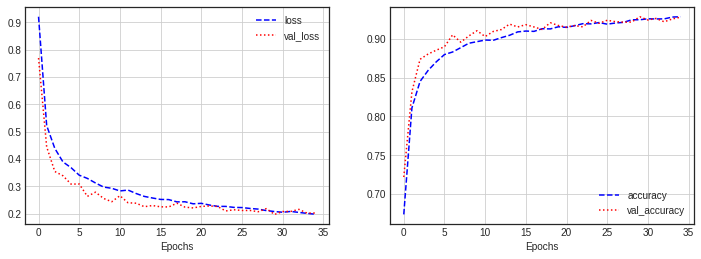

In [136]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure(figsize=(12,4))

plt.subplot(1, 2 ,1)
plt.plot(hist.history['loss'], 'b--', label='loss')
plt.plot(hist.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], 'b--', label='accuracy')
plt.plot(hist.history['val_acc'], 'r:', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

## 테스트 데이터로 결과 확인

- loss = 0.2098
- acc = 0.9242

In [137]:
model_1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2098 - acc: 0.9242


[0.20975163578987122, 0.9241999983787537]

# Mnist 분류 모델 성능 개선


## 필요한 라이브러리 불러오기

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

## 데이터 불러오기

In [ ]:
(x_train_full, y_train_full), (x_test, y_test) = load_data()

print(x_train_full.shape)
print(y_train_full.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 데이터 전처리

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3)

In [ ]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(42000, 28, 28)
(42000,)
(10000, 28, 28)
(10000,)
(18000, 28, 28)
(18000,)


In [ ]:
x_train[0].shape

(28, 28)

## 모델 만들기

In [ ]:
def build_model():
  model = Sequential()

  input = Input(shape=(28, 28, 1))
  output = Conv2D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=2, strides=2, padding='same')(output)

  output = Conv2D(filters=128, kernel_size=2, strides=2, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=2, strides=2, padding='same')(output)

  output = Conv2D(filters=256, kernel_size=2, strides=2, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=2, strides=2, padding='same')(output)
  output = Dropout(0.5)(output)

  output = Flatten()(output)
  output = Dense(units=128, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(units=64, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(units=10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

  return model

In [ ]:
model_1 = build_model()
model_1.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 128)         32896     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 256)         131328    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 256)        

## 모델 학습 (Callback 으로 EarlyStopping 사용)

In [ ]:
callbacks = EarlyStopping(patience=5, monitor='val_acc', 
                                  restore_best_weights=True)
hist = model_1.fit(x_train, y_train, epochs = 50, verbose=True, validation_data = (x_val, y_val), callbacks=callbacks)

Epoch 1/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.8158 - acc: 0.7336 - val_loss: 0.2327 - val_acc: 0.9318
Epoch 2/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.3169 - acc: 0.9178 - val_loss: 0.1706 - val_acc: 0.9504
Epoch 3/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.2472 - acc: 0.9358 - val_loss: 0.1431 - val_acc: 0.9614
Epoch 4/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.2106 - acc: 0.9469 - val_loss: 0.1408 - val_acc: 0.9623
Epoch 5/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1854 - acc: 0.9530 - val_loss: 0.1258 - val_acc: 0.9679
Epoch 6/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1693 - acc: 0.9582 - val_loss: 0.1311 - val_acc: 0.9656
Epoch 7/50
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1585 - acc: 0.9612 - val_loss: 0.1180 - val_acc: 0.9673
Epoch 8/50
1313/1313 [==============================] - 5s 4ms

In [ ]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## 결과 시각화

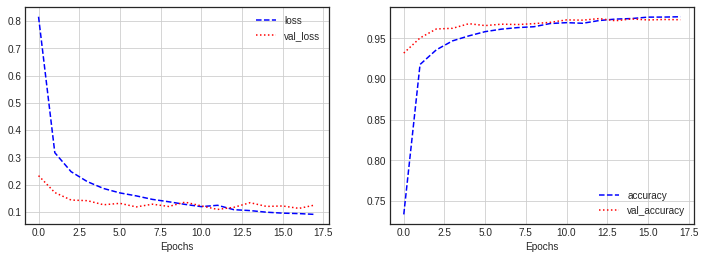

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure(figsize=(12,4))

plt.subplot(1, 2 ,1)
plt.plot(hist.history['loss'], 'b--', label='loss')
plt.plot(hist.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], 'b--', label='accuracy')
plt.plot(hist.history['val_acc'], 'r:', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

## 테스트 데이터로 결과 확인

- loss = 0.1016
- acc = 0.9768

In [ ]:
model_1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1016 - acc: 0.9768


[0.10161490738391876, 0.9768000245094299]